In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

In [24]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [25]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

### Retrieve Other Data

In [26]:
%store -r tests_df
%store -r citywide_all

# New York State Hospitalization / Discharge

## Processing

In [27]:
ny_state_hospitalization = pd.read_excel('data/new_york_state_hospitaliztion_and_discharge.xlsx')

In [28]:
ny_state_hospitalization['Cumulative Hospitalized'] = ny_state_hospitalization['Hospitalized'].cumsum() - ny_state_hospitalization['Discharged']

In [29]:
ny_state_hospitalization['Cumulative ICU'] = ny_state_hospitalization['ICU'].cumsum()
ny_state_hospitalization['Cumulative Intubations'] = ny_state_hospitalization['Intubations'].cumsum()
ny_state_hospitalization['Cumulative Discharged'] = ny_state_hospitalization['Discharged'].cumsum()

In [30]:
ny_state_hospitalization

,Date,Hospitalized,ICU,Discharged,Intubations,Cumulative Hospitalized,Cumulative ICU,Cumulative Intubations,Cumulative Discharged
0,2020-03-16,91,0,0,NaN,91,0,NaN,0
1,2020-03-17,170,46,0,43.0,261,46,43.0,0
2,2020-03-18,121,33,123,27.0,259,79,70.0,123
3,2020-03-19,425,104,78,93.0,729,183,163.0,201
4,2020-03-20,364,77,102,69.0,1069,260,232.0,303
5,2020-03-21,637,143,150,116.0,1658,403,348.0,453
6,2020-03-22,586,140,145,124.0,2249,543,472.0,598
7,2020-03-23,714,135,150,121.0,2958,678,593.0,748
8,2020-03-24,736,215,278,192.0,3566,893,785.0,1026
9,2020-03-25,1248,192,450,222.0,4642,1085,1007.0,1476


## Analysis

In [31]:
tests_df[tests_df['state'] == 'NY'][['Date', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently']]

,Date,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently
37,2020-04-05,16479.0,4376.0,NaN
93,2020-04-04,15905.0,4126.0,NaN
149,2020-04-03,14810.0,3731.0,NaN
205,2020-04-02,13383.0,3396.0,NaN
261,2020-04-01,12226.0,3022.0,NaN
317,2020-03-31,10929.0,2710.0,NaN
373,2020-03-30,9517.0,2352.0,NaN
429,2020-03-29,8503.0,2037.0,NaN
485,2020-03-28,7328.0,1755.0,NaN
541,2020-03-27,6481.0,1583.0,NaN


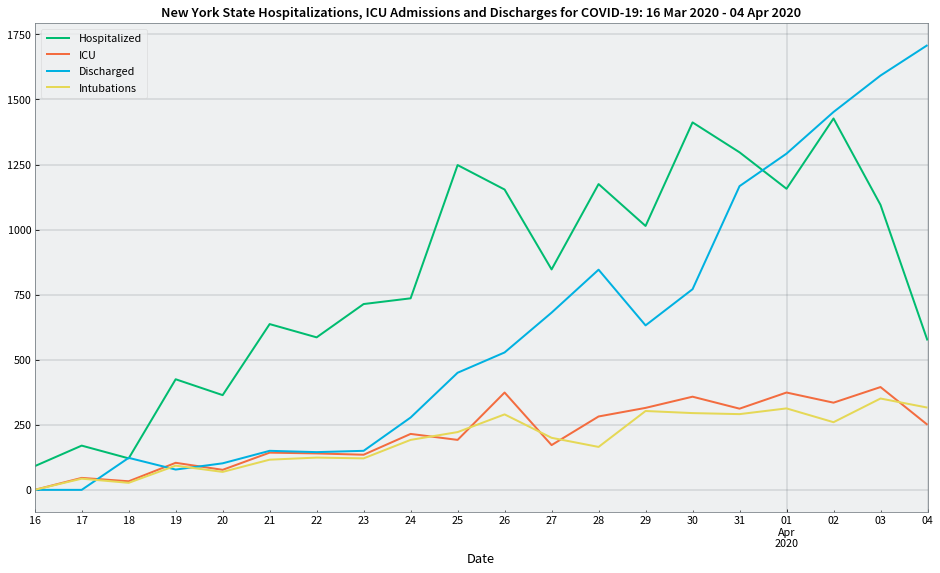

In [42]:
ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Discharged', 'Intubations']].sum().plot(kind='line',
                                                                                           title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

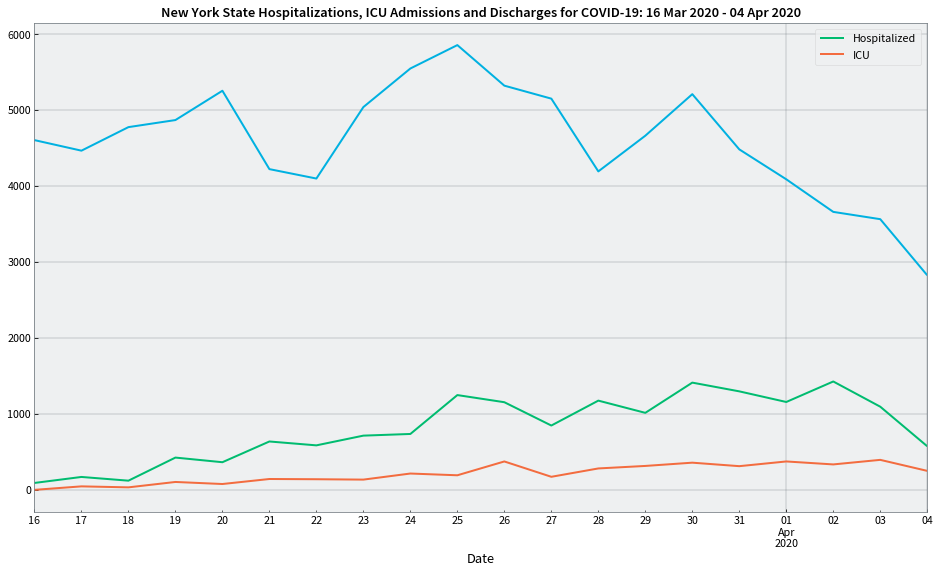

In [44]:
ax = ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU']].sum().plot(kind='line',
                                                                                  title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))
citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line', ax=ax)

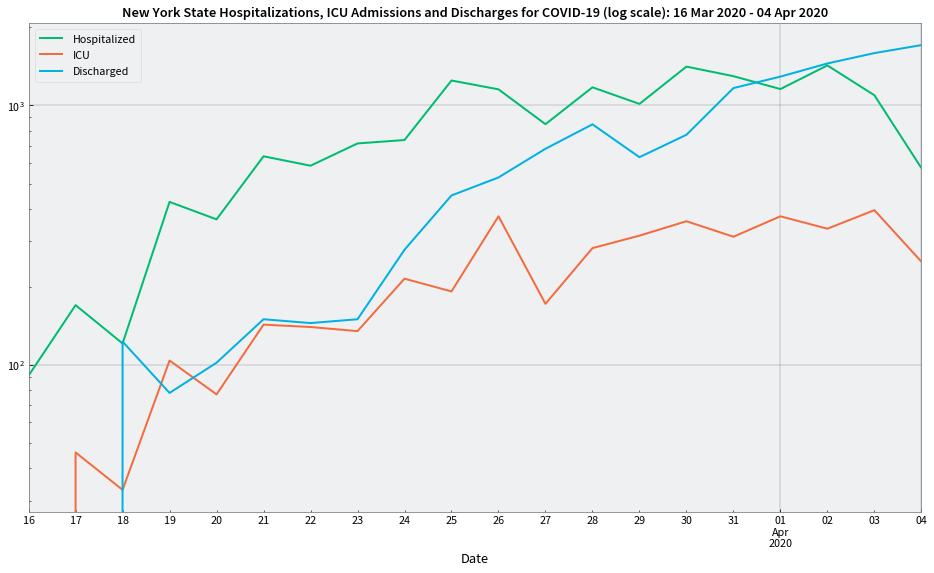

In [34]:
ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Discharged']].sum().plot(kind='line', logy=True,
                                                                                           title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19 (log scale): {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

In [35]:
ny_state_hospitalization['Cumulative Hospitalized'] = ny_state_hospitalization['Hospitalized'].cumsum() - ny_state_hospitalization['Discharged']

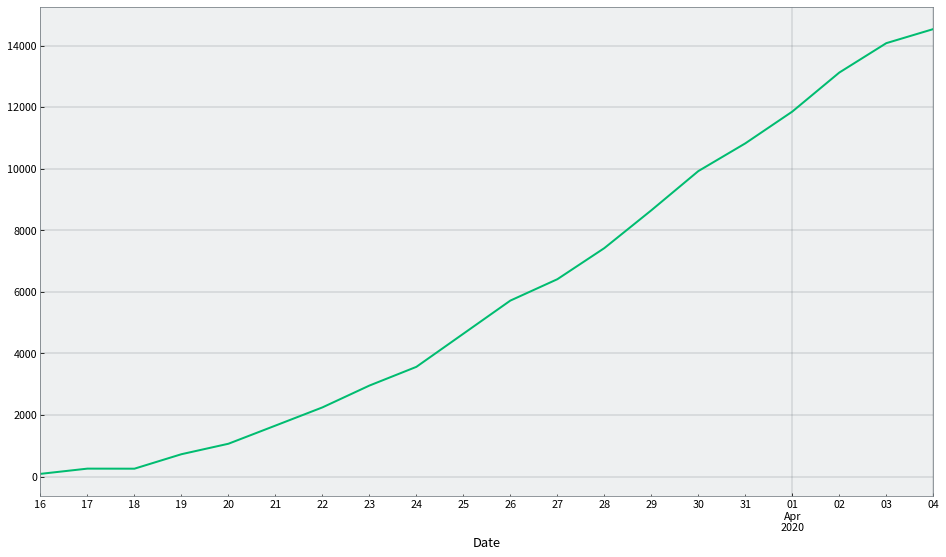

In [36]:
ny_state_hospitalization.groupby('Date')['Cumulative Hospitalized'].sum().plot(kind='line')

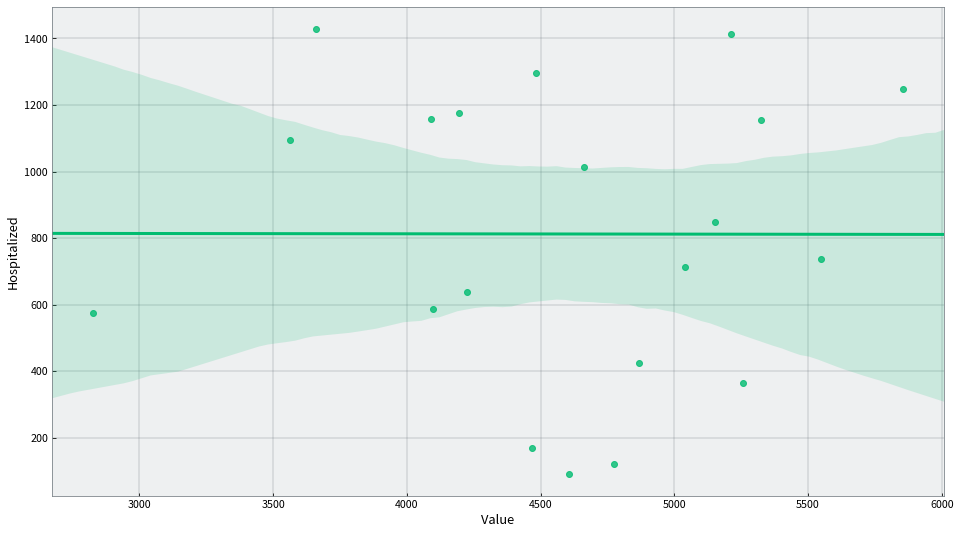

In [37]:
sns.regplot(y=ny_state_hospitalization['Hospitalized'],
            x=citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum())

In [38]:
(ny_state_hospitalization.groupby('Date')['Hospitalized'].sum() / citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum())

Date
2020-03-16    0.019761
2020-03-17    0.038065
2020-03-18    0.025335
2020-03-19    0.087287
2020-03-20    0.069267
2020-03-21    0.150841
2020-03-22    0.142962
2020-03-23    0.141667
2020-03-24    0.132660
2020-03-25    0.213115
2020-03-26    0.216836
2020-03-27    0.164434
2020-03-28    0.280229
2020-03-29    0.217457
2020-03-30    0.271017
2020-03-31    0.289315
2020-04-01    0.282954
2020-04-02    0.389891
2020-04-03    0.307239
2020-04-04    0.203186
dtype: float64

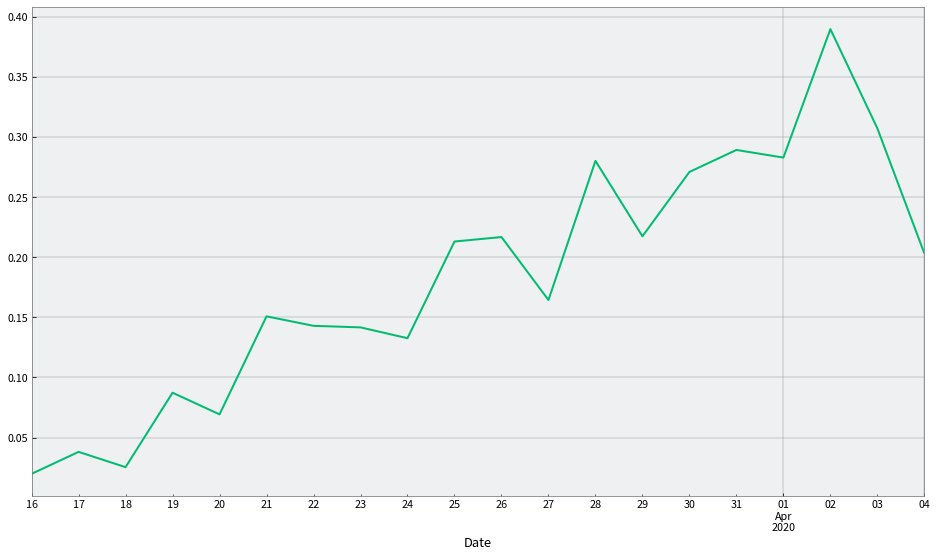

In [39]:
(ny_state_hospitalization.groupby('Date')['Hospitalized'].sum() / citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum()).plot(kind='line')

In [ ]:
ax = tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-16')].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests", stacked=False)
ny_state_hospitalization.groupby('Date')['Cumulative Hospitalized'].sum().plot(kind='line', color="#00b1e1")
ny_state_hospitalization.groupby('Date')['Cumulative ICU'].sum().plot(kind='line', color="#f36c3f")
cases_by_county[(cases_by_county['state'] == 'New York') & (cases_by_county['date'] >= '2020-03-16')].groupby('date')['deaths'].sum().plot(kind='line', color="#788086")

In [ ]:
cases_by_county[cases_by_county['state'] == 'New York'].groupby('date')['deaths'].sum()